# EX7 영화리뷰 텍스트 감성분석하기


- 평가문항

> **다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.**
 (3가지 이상의 모델이 성공적으로 시도)

> **gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.**
 (gendim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 분석)

> **한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.**
 (네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함)

********************
- Cloud shell에서 실행

ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data
**********************

### 1) 데이터 준비와 확인

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


# 데이터 파일 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords)제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [5]:
from konlpy.tag import Mecab
tokenizer = Mecab()

#불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)   # 중복 제거
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}    # {단어:숫자} 딕셔너리 생성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [6]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
print(X_train[0])
print(get_decoded_sentence(X_train[4], index_to_word))
print('라벨: ', y_train[4])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1


### 3) 데이터 분석 및 가공

- 적절한 최대 문장 길이를 찾아 지정

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


> padding 적용
- 모델의 종류에 따라 문장의 0을 채워 넣을 자리를 조정한다.['pre' 앞쪽, 'post' 뒤쪽]
- 예를들어, Many to Many와 Many to One의 두 가지 모델이 있고 지금 진행하고 있는 모델은 앞('pre')에 넣어야 성능이 좋아지기 때문에 'pre'를 사용한다.

In [11]:
X_train_pre = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test_pre = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(146182, 41)


In [12]:
print(X_train_pre[0])
print(get_decoded_sentence(X_train_pre[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


- padding이 'pre' 앞쪽에 배치 되었다.

### 4) 모델 구성 및 validation set 구성

- 45000개를 validation set으로 사용

In [13]:
# validation set 10000건 분리
X_val_pre = X_train_pre[:45000]    # pre 패딩된 train set 분리
y_val = y_train[:45000]

# validation set을 제외한 나머지
partial_X_train_pre = X_train_pre[45000:]
partial_y_train = y_train[45000:]


# validation set 갯수
print(X_val_pre.shape)
print(y_val.shape)

# 나머지 train set 갯수
print(partial_X_train_pre.shape)
print(partial_y_train.shape)

(45000, 41)
(45000,)
(101182, 41)
(101182,)


### 첫번째 RNN(Recurrent Neural Network)

In [14]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_pre = keras.Sequential()
model_rnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_pre.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_rnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_rnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_pre.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 두번째 CNN(Convolution Neural Network)

In [15]:

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_pre = keras.Sequential()
model_1dcnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.MaxPooling1D(5))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_pre.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 세번째 GlobalMaxPooling1D

In [16]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_pre = keras.Sequential()
model_gmp_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_pre.add(keras.layers.GlobalMaxPooling1D())
model_gmp_pre.add(keras.layers.Dense(8, activation='relu'))
model_gmp_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 5-1) 모델 학습 및 시각화['pre로 시도']

- RNN 모델 훈련

In [17]:
model_rnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_rnn_pre = model_rnn_pre.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 6s 14ms/step - loss: 0.6030 - accuracy: 0.7038 - val_loss: 0.3655 - val_accuracy: 0.8435
Epoch 2/10
198/198 [==============================] - 2s 11ms/step - loss: 0.3468 - accuracy: 0.8556 - val_loss: 0.3501 - val_accuracy: 0.8496
Epoch 3/10
198/198 [==============================] - 2s 12ms/step - loss: 0.3186 - accuracy: 0.8692 - val_loss: 0.3498 - val_accuracy: 0.8506
Epoch 4/10
198/198 [==============================] - 2s 11ms/step - loss: 0.3005 - accuracy: 0.8774 - val_loss: 0.3608 - val_accuracy: 0.8435
Epoch 5/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2986 - accuracy: 0.8790 - val_loss: 0.3574 - val_accuracy: 0.8458
Epoch 6/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2866 - accuracy: 0.8838 - val_loss: 0.3563 - val_accuracy: 0.8478
Epoch 7/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2819 - accuracy: 0.8866 - val_loss: 0.3590 - val_accuracy: 0.8472

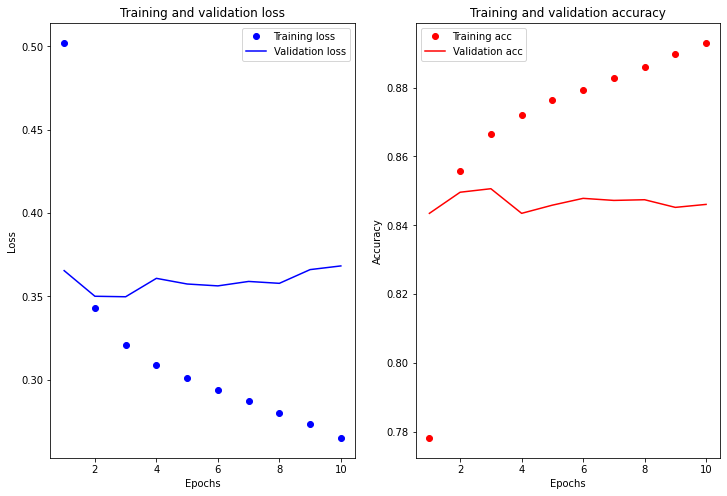

In [18]:
history_rnn_pre_dict = history_rnn_pre.history

acc = history_rnn_pre_dict['accuracy']
val_acc = history_rnn_pre_dict['val_accuracy']
loss = history_rnn_pre_dict['loss']
val_loss = history_rnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
results = model_rnn_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3809 - accuracy: 0.8391
[0.3809346556663513, 0.8391480445861816]


- CNN 모델 훈련

In [20]:

model_1dcnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_1dcnn_pre = model_1dcnn_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/10
198/198 [==============================] - 8s 26ms/step - loss: 0.6622 - accuracy: 0.5836 - val_loss: 0.4865 - val_accuracy: 0.7517
Epoch 2/10
198/198 [==============================] - 2s 8ms/step - loss: 0.4541 - accuracy: 0.7777 - val_loss: 0.4635 - val_accuracy: 0.7654
Epoch 3/10
198/198 [==============================] - 2s 9ms/step - loss: 0.4118 - accuracy: 0.8029 - val_loss: 0.4636 - val_accuracy: 0.7679
Epoch 4/10
198/198 [==============================] - 2s 8ms/step - loss: 0.3829 - accuracy: 0.8169 - val_loss: 0.4717 - val_accuracy: 0.7669
Epoch 5/10
198/198 [==============================] - 2s 8ms/step - loss: 0.3556 - accuracy: 0.8333 - val_loss: 0.4812 - val_accuracy: 0.7674
Epoch 6/10
198/198 [==============================] - 2s 8ms/step - loss: 0.3301 - accuracy: 0.8461 - val_loss: 0.5050 - val_accuracy: 0.7608
Epoch 7/10
198/198 [==============================] - 2s 8ms/step - loss: 0.3013 - accuracy: 0.8623 - val_loss: 0.5267 - val_accuracy: 0.7619
Epoch

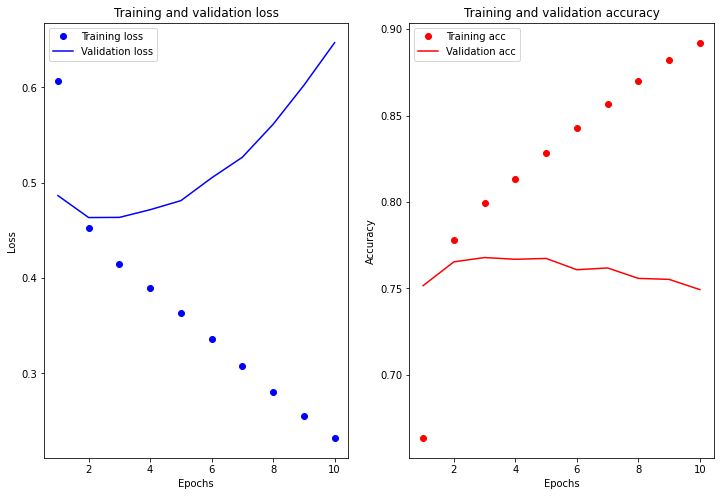

In [21]:
history_1dcnn_pre_dict = history_1dcnn_pre.history

acc = history_1dcnn_pre_dict['accuracy']
val_acc = history_1dcnn_pre_dict['val_accuracy']
loss = history_1dcnn_pre_dict['loss']
val_loss = history_1dcnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
results = model_1dcnn_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6538 - accuracy: 0.7448
[0.6537614464759827, 0.7447972893714905]


- GlobalMaxPooling 모델 훈련

In [23]:
model_gmp_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_gmp_pre = model_gmp_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/10
198/198 [==============================] - 2s 7ms/step - loss: 0.6717 - accuracy: 0.6605 - val_loss: 0.4822 - val_accuracy: 0.8083
Epoch 2/10
198/198 [==============================] - 1s 6ms/step - loss: 0.4308 - accuracy: 0.8253 - val_loss: 0.3745 - val_accuracy: 0.8350
Epoch 3/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3424 - accuracy: 0.8550 - val_loss: 0.3588 - val_accuracy: 0.8422
Epoch 4/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3117 - accuracy: 0.8695 - val_loss: 0.3559 - val_accuracy: 0.8449
Epoch 5/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2885 - accuracy: 0.8803 - val_loss: 0.3579 - val_accuracy: 0.8457
Epoch 6/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2681 - accuracy: 0.8910 - val_loss: 0.3629 - val_accuracy: 0.8455
Epoch 7/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2498 - accuracy: 0.8998 - val_loss: 0.3707 - val_accuracy: 0.8446
Epoch 

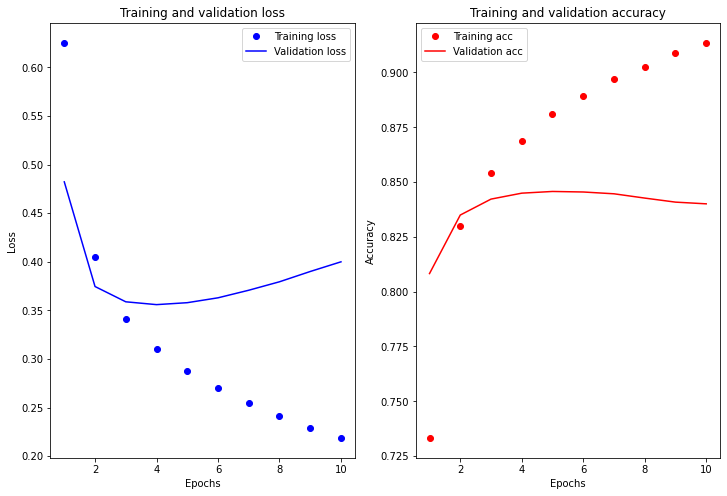

In [24]:

history_gmp_pre_dict = history_gmp_pre.history

acc = history_gmp_pre_dict['accuracy']
val_acc = history_gmp_pre_dict['val_accuracy']
loss = history_gmp_pre_dict['loss']
val_loss = history_gmp_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
results = model_gmp_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4135 - accuracy: 0.8333
[0.4134535491466522, 0.833268940448761]


|모델|pre padding 정확도|
|------|---|
|RNN(LSTM)|0.8403|
|CNN|0.7418|
|GlobalMaxPooling|0.8431|

*********************
### 5-2) 모델 학습 및 시각화['post로 시도']

In [26]:

X_train_post = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test_post = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=maxlen)

print(X_train_post.shape)

(146182, 41)


In [27]:
print(X_train_post[0])
print(get_decoded_sentence(X_train_post[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  0


In [28]:
X_val_post = X_train_post[:45000]

partial_X_train_post = X_train_post[45000:]

print(X_val_post.shape)

print(partial_X_train_post.shape)

(45000, 41)
(101182, 41)


- RNN 모델 훈련

In [29]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_post = keras.Sequential()
model_rnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_post.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_rnn_post.add(keras.layers.Dense(8, activation='relu'))
model_rnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_post.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_rnn_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_rnn_post = model_rnn_post.fit(partial_X_train_post,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 5s 14ms/step - loss: 0.6795 - accuracy: 0.5289 - val_loss: 0.4595 - val_accuracy: 0.8177
Epoch 2/10
198/198 [==============================] - 2s 11ms/step - loss: 0.4062 - accuracy: 0.8383 - val_loss: 0.3591 - val_accuracy: 0.8428
Epoch 3/10
198/198 [==============================] - 2s 11ms/step - loss: 0.3263 - accuracy: 0.8664 - val_loss: 0.3482 - val_accuracy: 0.8493
Epoch 4/10
198/198 [==============================] - 2s 11ms/step - loss: 0.3034 - accuracy: 0.8768 - val_loss: 0.3534 - val_accuracy: 0.8482
Epoch 5/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2946 - accuracy: 0.8813 - val_loss: 0.3522 - val_accuracy: 0.8471
Epoch 6/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2873 - accuracy: 0.8844 - val_loss: 0.3599 - val_accuracy: 0.8464
Epoch 7/10
198/198 [==============================] - 2s 11ms/step - loss: 0.2793 - accuracy: 0.8872 - val_loss: 0.3604 - val_accuracy: 0.8443

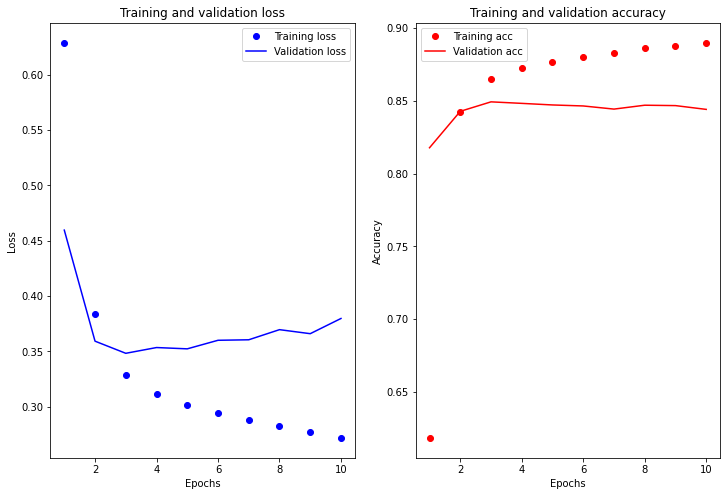

In [31]:
history_rnn_post_dict = history_rnn_post.history

acc = history_rnn_post_dict['accuracy']
val_acc = history_rnn_post_dict['val_accuracy']
loss = history_rnn_post_dict['loss']
val_loss = history_rnn_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
results = model_rnn_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3891 - accuracy: 0.8373
[0.3890856206417084, 0.8373374938964844]


- CNN 모델 훈련

In [33]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_post = keras.Sequential()
model_1dcnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_post.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_post.add(keras.layers.MaxPooling1D(5))
model_1dcnn_post.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_post.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_post.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_post.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [34]:
model_1dcnn_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_1dcnn_post = model_1dcnn_post.fit(partial_X_train_post,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_post, y_val),
                                       verbose=1)

Epoch 1/10
198/198 [==============================] - 3s 9ms/step - loss: 0.6482 - accuracy: 0.6105 - val_loss: 0.3735 - val_accuracy: 0.8354
Epoch 2/10
198/198 [==============================] - 2s 8ms/step - loss: 0.3418 - accuracy: 0.8542 - val_loss: 0.3435 - val_accuracy: 0.8518
Epoch 3/10
198/198 [==============================] - 2s 8ms/step - loss: 0.2934 - accuracy: 0.8777 - val_loss: 0.3415 - val_accuracy: 0.8536
Epoch 4/10
198/198 [==============================] - 2s 8ms/step - loss: 0.2709 - accuracy: 0.8896 - val_loss: 0.3494 - val_accuracy: 0.8523
Epoch 5/10
198/198 [==============================] - 2s 8ms/step - loss: 0.2432 - accuracy: 0.9043 - val_loss: 0.3591 - val_accuracy: 0.8487
Epoch 6/10
198/198 [==============================] - 2s 8ms/step - loss: 0.2231 - accuracy: 0.9151 - val_loss: 0.3701 - val_accuracy: 0.8474
Epoch 7/10
198/198 [==============================] - 2s 8ms/step - loss: 0.2006 - accuracy: 0.9257 - val_loss: 0.3928 - val_accuracy: 0.8464
Epoch 

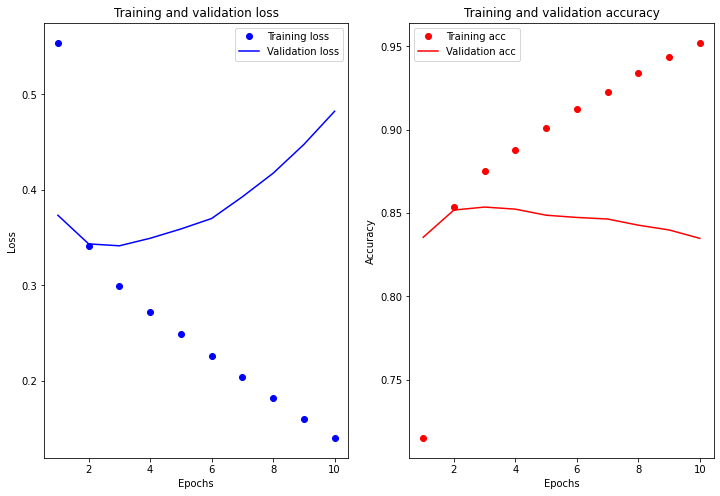

In [35]:
history_1dcnn_post_dict = history_1dcnn_post.history

acc = history_1dcnn_post_dict['accuracy']
val_acc = history_1dcnn_post_dict['val_accuracy']
loss = history_1dcnn_post_dict['loss']
val_loss = history_1dcnn_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [36]:
results = model_1dcnn_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4903 - accuracy: 0.8315
[0.4903475046157837, 0.8315194249153137]


- GlobalMaxpooling 모델 훈련

In [37]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_post = keras.Sequential()
model_gmp_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_post.add(keras.layers.GlobalMaxPooling1D())
model_gmp_post.add(keras.layers.Dense(8, activation='relu'))
model_gmp_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_post.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_gmp_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_gmp_post = model_gmp_post.fit(partial_X_train_post,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_post, y_val),
                                       verbose=1)

Epoch 1/10
198/198 [==============================] - 2s 7ms/step - loss: 0.6675 - accuracy: 0.6672 - val_loss: 0.4900 - val_accuracy: 0.8084
Epoch 2/10
198/198 [==============================] - 1s 6ms/step - loss: 0.4430 - accuracy: 0.8248 - val_loss: 0.3769 - val_accuracy: 0.8348
Epoch 3/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3465 - accuracy: 0.8556 - val_loss: 0.3574 - val_accuracy: 0.8426
Epoch 4/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3101 - accuracy: 0.8726 - val_loss: 0.3531 - val_accuracy: 0.8448
Epoch 5/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2818 - accuracy: 0.8867 - val_loss: 0.3554 - val_accuracy: 0.8454
Epoch 6/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2633 - accuracy: 0.8947 - val_loss: 0.3618 - val_accuracy: 0.8445
Epoch 7/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2444 - accuracy: 0.9037 - val_loss: 0.3708 - val_accuracy: 0.8431
Epoch 

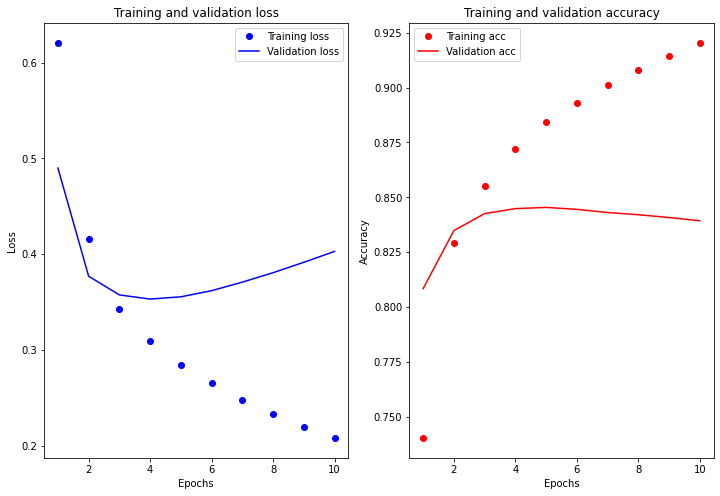

In [39]:
history_gmp_post_dict = history_gmp_post.history

acc = history_gmp_post_dict['accuracy']
val_acc = history_gmp_post_dict['val_accuracy']
loss = history_gmp_post_dict['loss']
val_loss = history_gmp_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [40]:
results = model_gmp_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4113 - accuracy: 0.8358
[0.41134580969810486, 0.8357914686203003]


|모델|post padding 정확도|
|------|---|
|RNN(LSTM)|0.8388|
|CNN|0.8332|
|GlobalMaxPooling|0.8363|

*******************************

> **CNN은** pre padding 보다 **post padding에 적합**하다.


### 6) 임베딩 레이어 분석

- Embedding 레이어는 우리가 가진 사전의 단어 갯수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터이고, 학습이 잘 됐다면 워드 벡터들이 의미 공간상에 유의미한 형태로 남아있을 것이다.
- pre padding 이용 RNN 모델

In [41]:
embedding_layer = model_rnn_pre.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [42]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model_rnn_pre.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [43]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("환상")

[('이곳', 0.963407039642334),
 ('86', 0.9568414688110352),
 ('찡', 0.9557399153709412),
 ('메이퀸', 0.9546241760253906),
 ('엑스', 0.9541471004486084),
 ('저희', 0.9534773230552673),
 ('퍼펙트', 0.953449010848999),
 ('소외', 0.9530998468399048),
 ('함부로', 0.9523816108703613),
 ('충분', 0.9510347247123718)]

In [44]:
word_vectors.similar_by_word("장인")

[('님', 0.8737066388130188),
 ('소림축구', 0.8668602108955383),
 ('지극히', 0.8518191576004028),
 ('찍히', 0.8399199843406677),
 ('바르', 0.8390517830848694),
 ('윤제문', 0.8379800915718079),
 ('안목', 0.8339184522628784),
 ('니매', 0.833432674407959),
 ('처', 0.8301059007644653),
 ('투영', 0.82972651720047)]

> ???이상하다. 단어를 입력했을때, 가장 유사한 단어와 유사도를 확인했지만, 성능의 개선이 필요하다.

### 7) Word2Vec 임베딩을 활용하여 성능 개선

In [45]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['행복']
vector.shape     # 200dim의 워드 벡터

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(200,)

In [46]:
word2vec.similar_by_word("바다")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('육지', 0.7259926795959473),
 ('호수', 0.6840913891792297),
 ('바닷속', 0.6585341691970825),
 ('바닷가', 0.6451719403266907),
 ('늪', 0.6421072483062744),
 ('급류', 0.6311373710632324),
 ('바닷물', 0.6305385231971741),
 ('절벽', 0.6251566410064697),
 ('바위', 0.6213432550430298),
 ('골짜기', 0.6192145347595215)]

In [47]:
word2vec.similar_by_word("지구")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('지구의', 0.7076486349105835),
 ('태양계', 0.5700592398643494),
 ('내행성', 0.5400351881980896),
 ('행성', 0.5400117635726929),
 ('생물권', 0.5392104387283325),
 ('태양', 0.5347169041633606),
 ('외행성', 0.5323898792266846),
 ('달의', 0.5301944017410278),
 ('시가지', 0.5279563665390015),
 ('대기권', 0.5260995626449585)]

In [48]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [49]:
# LSTM 레이어로 모델 설계
model_ko = keras.Sequential()
model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(keras.layers.LSTM(128))  # LSTM state 벡터의 차원수 (변경가능)
model_ko.add(keras.layers.Dense(8, activation='relu'))
model_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_ko.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10   

history_ko = model_ko.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/10
1581/1581 [==============================] - 38s 23ms/step - loss: 0.4735 - accuracy: 0.7650 - val_loss: 0.3348 - val_accuracy: 0.8558
Epoch 2/10
1581/1581 [==============================] - 36s 22ms/step - loss: 0.2977 - accuracy: 0.8725 - val_loss: 0.3142 - val_accuracy: 0.8658
Epoch 3/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.2452 - accuracy: 0.8983 - val_loss: 0.3189 - val_accuracy: 0.8677
Epoch 4/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.2009 - accuracy: 0.9194 - val_loss: 0.3340 - val_accuracy: 0.8662
Epoch 5/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.1604 - accuracy: 0.9358 - val_loss: 0.3709 - val_accuracy: 0.8595
Epoch 6/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.1238 - accuracy: 0.9528 - val_loss: 0.4288 - val_accuracy: 0.8637
Epoch 7/10
1581/1581 [==============================] - 35s 22ms/step - loss: 0.0892 - accuracy: 0.9661 - val_loss: 0.4947 -

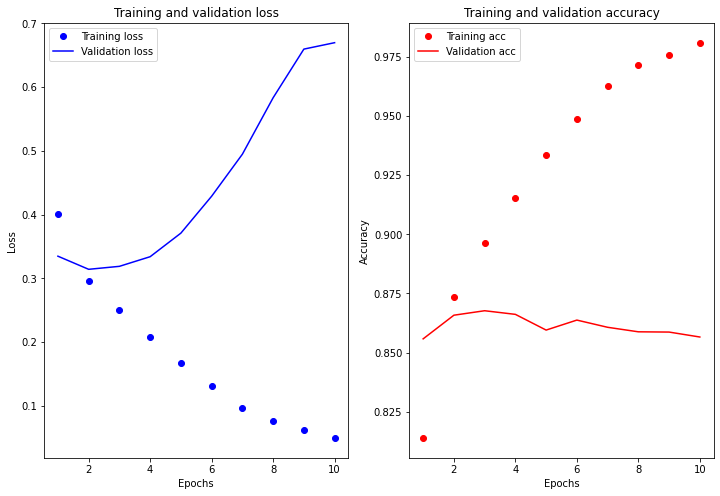

In [51]:
history_ko_dict = history_ko.history

acc = history_ko_dict['accuracy']
val_acc = history_ko_dict['val_accuracy']
loss = history_ko_dict['loss']
val_loss = history_ko_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [52]:
results = model_ko.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.6873 - accuracy: 0.8514
[0.6873288154602051, 0.851394534111023]


### 8) Dropout 추가

- 팀원분들의 추천으로! overfitting 문제를 해결하고, 정규화된 모델을 만들기 위해 network 일부를 생략하는 방법을 쓰면 좋은 결과를 얻을 수 있다기에 사용해 봤다.

In [53]:
# LSTM 레이어로 모델 설계
model_ko_final = keras.Sequential()
model_ko_final.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko_final.add(keras.layers.LSTM(128))  # LSTM state 벡터의 차원수 (변경가능)
model_ko_final.add(keras.layers.Dropout(0.25))                    # Dropout 추가
model_ko_final.add(keras.layers.Dense(8, activation='relu'))
model_ko_final.add(keras.layers.Dropout(0.3))                     # Dropout 추가
model_ko_final.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim
model_ko_final.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
____________________________________________

In [54]:
model_ko_final.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10   

history_ko_final = model_ko_final.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/10
1581/1581 [==============================] - 38s 23ms/step - loss: 0.5350 - accuracy: 0.7340 - val_loss: 0.3430 - val_accuracy: 0.8528
Epoch 2/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.3517 - accuracy: 0.8612 - val_loss: 0.3229 - val_accuracy: 0.8619
Epoch 3/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.2969 - accuracy: 0.8859 - val_loss: 0.3173 - val_accuracy: 0.8664
Epoch 4/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.2622 - accuracy: 0.8993 - val_loss: 0.3274 - val_accuracy: 0.8647
Epoch 5/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.2278 - accuracy: 0.9139 - val_loss: 0.3565 - val_accuracy: 0.8638
Epoch 6/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.1928 - accuracy: 0.9297 - val_loss: 0.3712 - val_accuracy: 0.8631
Epoch 7/10
1581/1581 [==============================] - 36s 23ms/step - loss: 0.1659 - accuracy: 0.9415 - val_loss: 0.4024 -

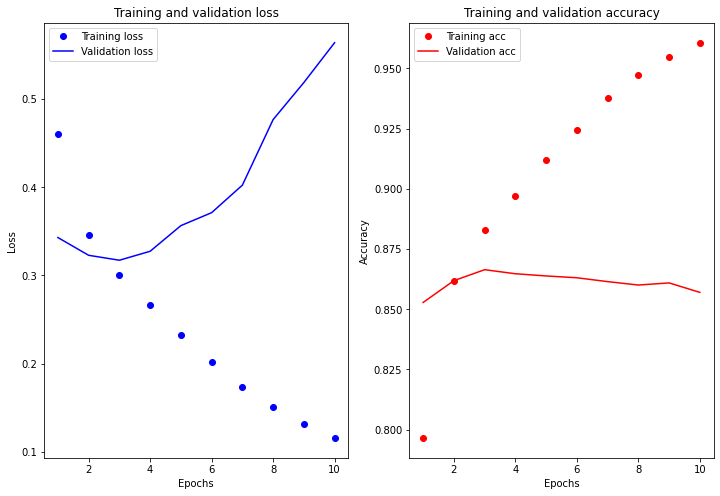

In [55]:
history_ko_final_dict = history_ko_final.history

acc = history_ko_final_dict['accuracy']
val_acc = history_ko_final_dict['val_accuracy']
loss = history_ko_final_dict['loss']
val_loss = history_ko_final_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [56]:
results = model_ko_final.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.5656 - accuracy: 0.8520
[0.5656407475471497, 0.8520048260688782]


- Dropout을 추가하여 모델을 생성했을때, 0.8520으로 아주 소폭 상승했다.
- 그래프도 보다 이쁘게 나왔다.

*********************
## 회고

>Maxlen을 적절하게 잘 지정한것 같다. 정확도가 생각보다 높게 나왔다.

>Many to Many, Many to One 의 모델에 따른 padding의 post와 pre 결정
>[CNN은 post padding이 적절했고, RNN은 pre padding이 적절했다.]

>얼마나 DEEP하게 쌓을 것이냐는 모델마다 잘 지정해야하고, 항상 "적절하게"라는 말이 어렵기 때문에, 보다 많은 시도를 통해 감을 넓혀야겠다.


>LSTM의 수를 8에서 128로 변경했을때 더 많이 저장할 수 있는 양이 늘어난다고 한다.(어떤 수가 가장 적합한지 찾아보지는 않았다.)

> 사실상 정확도가 확실하게 오르지는 않았지만, 변화를 줌으로써 최적화된 결과를 찾아가는 것에 만족한다.